In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/dataset/CNN_faces_expresions/archive.zip"
extract_path = "/content/fer2013"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction done!")


Extraction done!


In [ ]:
import os

os.listdir("/content/fer2013")
os.listdir("/content/fer2013/train")



['disgust', 'fear', 'happy', 'neutral', 'angry', 'surprise', 'sad']

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
# 48x48 grayscale images, 7 emotion classes
num_classes = 7
input_shape = (48, 48, 1)  # grayscale

model = Sequential([
    # Block 1
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # softmax for multi-class
])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,935 (2.61 MB)

 Trainable params: 684,231 (2.61 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('fer_model.h5', monitor='val_loss', save_best_only=True)
]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale pixels & validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    "/content/fer2013/train",
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    "/content/fer2013/train",
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical",
    subset="validation",
    shuffle=True
)

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "/content/fer2013/test",
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical",
    shuffle=False
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2464 - loss: 2.2817

359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 53ms/step - accuracy: 0.2465 - loss: 2.2808 - val_accuracy: 0.2768 - val_loss: 2.0193
Epoch 2/50
357/359 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3926 - loss: 1.5806

359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.3927 - loss: 1.5803 - val_accuracy: 0.3848 - val_loss: 1.5944
Epoch 3/50
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4604 - loss: 1.4299

359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.4604 - loss: 1.4298 - val_accuracy: 0.4903 - val_loss: 1.3462
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.4847 - loss: 1.3459 - val_accuracy: 0.4696 - val_loss: 1.4175
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5015 - loss: 1.3150 - val_accuracy: 0.4849 - val_loss: 1.6903
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5169 - loss: 1.2751

359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5169 - loss: 1.2751 - val_accuracy: 0.5365 - val_loss: 1.2182
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5269 - loss: 1.2572 - val_accuracy: 0.4909 - val_loss: 1.3569
Epoch 8/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.5385 - loss: 1.2280 - val_accuracy: 0.5401 - val_loss: 1.2427
Epoch 9/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5486 - loss: 1.1979 - val_accuracy: 0.4773 - val_loss: 1.3688
Epoch 10/50
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5558 - loss: 1.1795

359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.5558 - loss: 1.1795 - val_accuracy: 0.5471 - val_loss: 1.1951
Epoch 11/50
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5632 - loss: 1.1675

359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.5632 - loss: 1.1675 - val_accuracy: 0.5445 - val_loss: 1.1833
Epoch 12/50
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5724 - loss: 1.1395

359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5724 - loss: 1.1396 - val_accuracy: 0.5692 - val_loss: 1.1217
Epoch 13/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5686 - loss: 1.1309 - val_accuracy: 0.5659 - val_loss: 1.1566
Epoch 14/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5812 - loss: 1.1011 - val_accuracy: 0.5649 - val_loss: 1.1679
Epoch 15/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5827 - loss: 1.1064 - val_accuracy: 0.5450 - val_loss: 1.2215
Epoch 16/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5909 - loss: 1.1033 - val_accuracy: 0.5668 - val_loss: 1.1533
Epoch 17/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5983 - loss: 1.0758

359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.5983 - loss: 1.0759 - val_accuracy: 0.5766 - val_loss: 1.1174
Epoch 18/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.5985 - loss: 1.0749 - val_accuracy: 0.5710 - val_loss: 1.1426
Epoch 19/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.6028 - loss: 1.0588 - val_accuracy: 0.4966 - val_loss: 1.3206
Epoch 20/50
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6036 - loss: 1.0579

359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.6036 - loss: 1.0579 - val_accuracy: 0.5948 - val_loss: 1.0945
Epoch 21/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.6131 - loss: 1.0321 - val_accuracy: 0.5804 - val_loss: 1.1282
Epoch 22/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.6183 - loss: 1.0246 - val_accuracy: 0.5539 - val_loss: 1.1957
Epoch 23/50
357/359 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6186 - loss: 1.0255

359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.6185 - loss: 1.0256 - val_accuracy: 0.5966 - val_loss: 1.0786
Epoch 24/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.6181 - loss: 1.0159 - val_accuracy: 0.5724 - val_loss: 1.1615
Epoch 25/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.6298 - loss: 0.9941 - val_accuracy: 0.5166 - val_loss: 1.8390
Epoch 26/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.6283 - loss: 0.9822 - val_accuracy: 0.5736 - val_loss: 1.1685
Epoch 27/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.6298 - loss: 0.9836 - val_accuracy: 0.5699 - val_loss: 1.1253
Epoch 28/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.6314 - loss: 0.9857 - val_accuracy: 0.5515 - val_loss: 1.1896


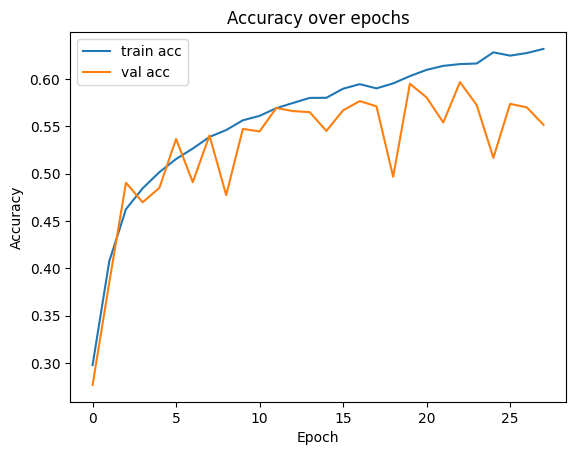

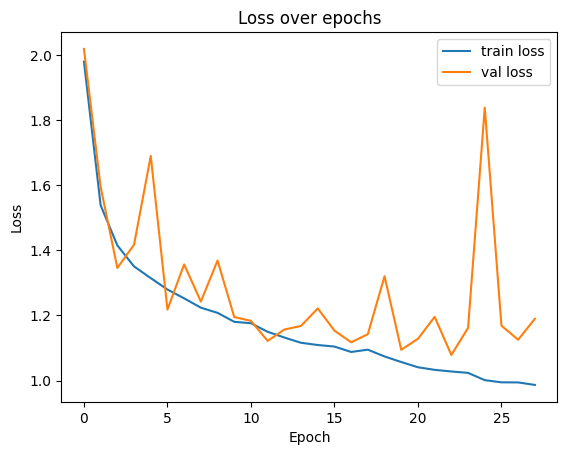

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5484 - loss: 1.1710
Test Accuracy: 59.43%


In [ ]:
model.save("/content/drive/MyDrive/models/fer2013_cnn_model.h5")
